# Noise2Self for Astro

In astronomy datasets, one often acquires many images of the same part of the sky, with different shot, read-out, cosmic ray, and detector noise. Instead of averaging those images, we may train a network to predict one from the other. The resulting output will be a denoised image.

In the simplest case, we have two or more images, and we may use one two predict the other (the Noise2Noise regime). Given more images, we may design a more complicated architecture to take advantage of their multiplicity (instead of merely averaging them to make pairs).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

# Nord Data

In [204]:
import h5py
hf = h5py.File('../data/data_astro_sim_v20190509_samescale.h5', 'r')
data = hf.get('imageset')

Below are two measurements of the same (synthetic) region of the sky.

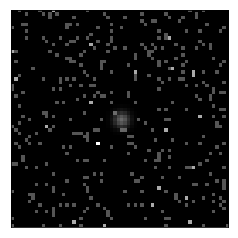

In [205]:
show(data[0,0], vmax = 3)

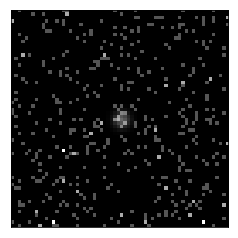

In [206]:
 show(data[0,1], vmax = 3)

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [207]:
from models.babyunet import BabyUnet
model = BabyUnet()

In [208]:
from util import getbestgpu
# device = getbestgpu()
device = 0

In [209]:
model = model.to(device)

# Training

In [210]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0003)

In [211]:
data_loader = DataLoader(data, batch_size=32, shuffle=False)

In [212]:
n_epochs = 1
for epoch in range(n_epochs):
    for i, batch in enumerate(data_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

#         if i % 50 == 0:
#             print("Loss (", i, "): \t", round(loss.item(), 4))

In [213]:
test_data_loader = DataLoader(data,
                              batch_size=32,
                              shuffle=False)
i, test_batch = next(enumerate(test_data_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:1], test_batch[:,1:2]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

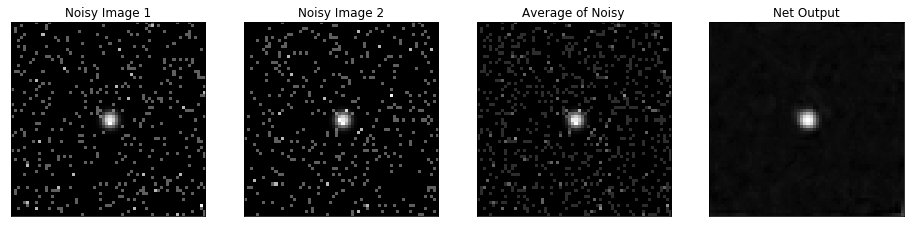

In [214]:
output = model(noisy_images_1.to(device))
idx = 12
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

# Real Data

In [215]:
from glob import glob
import os
from collections import defaultdict, Counter
from skimage.io import imread

In [216]:
fnames = glob('../data/cutouts/*.png')

In [217]:
for file in fnames:
    im = imread(file)
    shapes[im.shape] += 1

In [218]:
shapes.most_common(3)

[((137, 137), 188), ((137, 120), 3), ((137, 116), 2)]

In [219]:
shape = shapes.most_common(3)[0][0]

In [220]:
patches = defaultdict(lambda: defaultdict(list))
shapes = Counter()
bands = set()
for file in fnames:
    patch, band, date = os.path.splitext(os.path.basename(file))[0].split('_')
    im = imread(file)
    if im.shape != shape:
        continue
    patches[patch][band].append(im)
    bands.add(band)

In [221]:
import numpy as np

In [222]:
print("There are ", len(patches), " patches.")
print("There bands are ", bands, ".")

There are  9  patches.
There bands are  {'i', 'r', 'Y', 'g', 'z'} .


In [223]:
# data = np.stack([(patches[patch]['i'][0], patches[patch]['i'][1]) for patch in patches])

In [224]:
data = np.stack([(patches[patch][b][0], patches[patch][b][1]) for patch in patches for b in bands])

In [225]:
clipped_data = data[:,:,:128,:128]/255

In [226]:
model = BabyUnet()
model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0003)

data_loader = DataLoader(clipped_data, batch_size=9, shuffle=False)

In [228]:
# Predict noisy2 from noisy1

In [227]:
n_epochs = 200

for epoch in range(n_epochs):
    for i, batch in enumerate(data_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(loss.item(), 4))

Loss ( 0 ): 	 0.7171
Loss ( 10 ): 	 0.0445
Loss ( 20 ): 	 0.0358
Loss ( 30 ): 	 0.0337
Loss ( 40 ): 	 0.0328
Loss ( 50 ): 	 0.0323
Loss ( 60 ): 	 0.0319
Loss ( 70 ): 	 0.0317
Loss ( 80 ): 	 0.0314
Loss ( 90 ): 	 0.0313
Loss ( 100 ): 	 0.0312
Loss ( 110 ): 	 0.0311
Loss ( 120 ): 	 0.031
Loss ( 130 ): 	 0.0309
Loss ( 140 ): 	 0.0309
Loss ( 150 ): 	 0.0308
Loss ( 160 ): 	 0.0308
Loss ( 170 ): 	 0.0307
Loss ( 180 ): 	 0.0307
Loss ( 190 ): 	 0.0306


In [229]:
test_data_loader = DataLoader(clipped_data,
                              batch_size=9,
                              shuffle=False)
i, test_batch = next(enumerate(test_data_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:1], test_batch[:,1:2]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

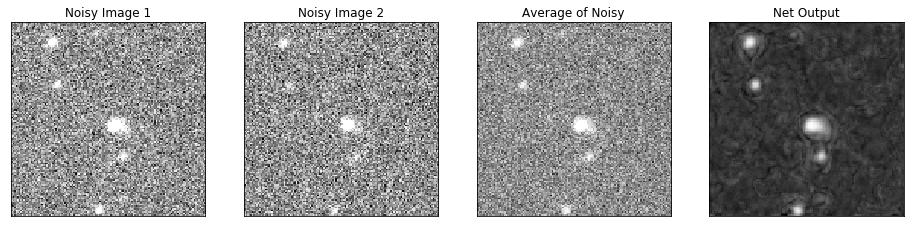

In [230]:
output = model(noisy_images_1.to(device))
idx = 0
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

# Multichannel Input

In [231]:
data = np.stack([patches[patch][b][0:3] for patch in patches for b in bands])

In [232]:
clipped_data = data[:,:,:128,:128]/255

In [233]:
clipped_data.shape

(45, 3, 128, 128)

In [234]:
model = BabyUnet(2, 1)
model.to(device)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0003)

data_loader = DataLoader(clipped_data, batch_size=9, shuffle=False)

In [236]:
n_epochs = 200

for epoch in range(n_epochs):
    for i, batch in enumerate(data_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:2], batch[:,2:3]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if epoch % 10 == 0:
        print("Loss (", epoch, "): \t", round(loss.item(), 4))

Loss ( 0 ): 	 0.031
Loss ( 10 ): 	 0.0308
Loss ( 20 ): 	 0.0307
Loss ( 30 ): 	 0.0306
Loss ( 40 ): 	 0.0305
Loss ( 50 ): 	 0.0304
Loss ( 60 ): 	 0.0303
Loss ( 70 ): 	 0.0303
Loss ( 80 ): 	 0.0303
Loss ( 90 ): 	 0.0302
Loss ( 100 ): 	 0.0302
Loss ( 110 ): 	 0.0301
Loss ( 120 ): 	 0.0301
Loss ( 130 ): 	 0.0301
Loss ( 140 ): 	 0.03
Loss ( 150 ): 	 0.03
Loss ( 160 ): 	 0.03
Loss ( 170 ): 	 0.0299
Loss ( 180 ): 	 0.0299
Loss ( 190 ): 	 0.0299


In [237]:
test_data_loader = DataLoader(clipped_data,
                              batch_size=9,
                              shuffle=False)
i, test_batch = next(enumerate(test_data_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:2], test_batch[:,2:3]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)


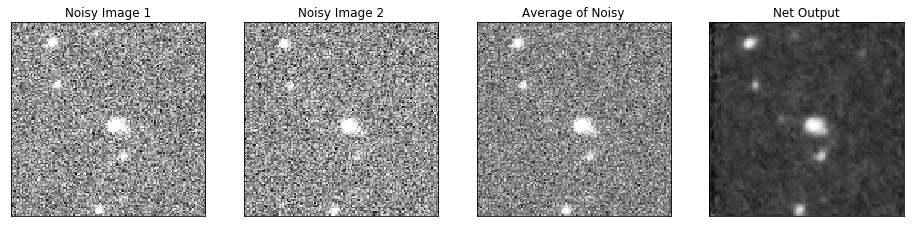

In [238]:
output = model(noisy_images_1.to(device))
idx = 0
plot_tensors([noisy_images_1[idx][0],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx][0] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

Cyclicly feed the two inputs in.

In [239]:
output = (model(test_batch[:,0:2].to(device)) +
          model(test_batch[:,1:3].to(device)) + 
          model(test_batch[:,np.array([0,2])].to(device)))/3

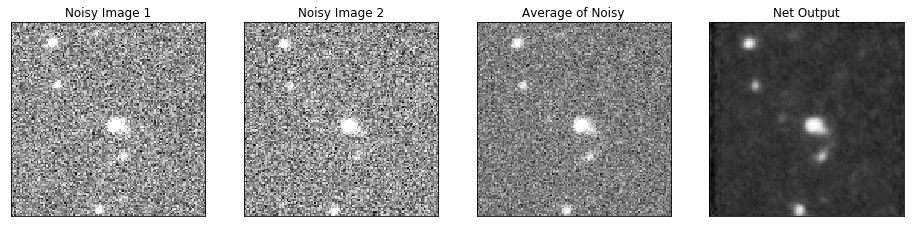

In [240]:
# output = model(noisy_images_1.to(device))
idx = 0
plot_tensors([noisy_images_1[idx][0],
              noisy_images_2[idx],
              (test_batch[0].mean(dim = 0)),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])

Compare to classical methods

In [242]:
from skimage.filters import median
from skimage.restoration import denoise_wavelet, denoise_nl_means

/home/batson/miniconda3/envs/pytorch/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


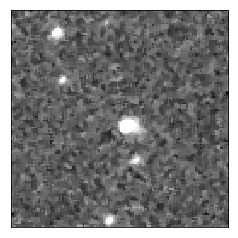

In [243]:
show(median(noisy_images_1[idx][0].cpu().detach().numpy()))

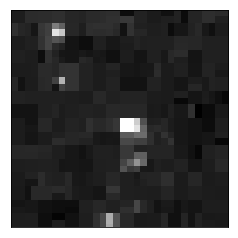

In [244]:
show(denoise_wavelet(noisy_images_1[idx][0].cpu().detach().numpy()))

/home/batson/miniconda3/envs/pytorch/lib/python3.6/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


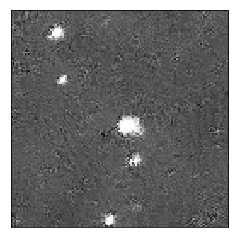

In [245]:
show(denoise_nl_means(noisy_images_1[idx][0].cpu().detach().numpy()))